# Sentiment Analysis

### NLP workflow

<img src="resources/pipeline.png">

In [1]:
import os
import re
import string
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from tqdm.auto import tqdm
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

# for BERT
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

pd.set_option("max_colwidth", 500) # Set display column width to show more content

In [2]:
# If this is the first time you use nltk, make sure to download necessary resources and pre-trained models

# nltk.download()

## Get familiar with dataset

In [25]:
df = pd.read_csv('./IMDB-Dataset.csv')

df

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is calle...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly wr...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />T...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ru...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is conne...",positive
...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lotta fun. the more i think about it the more i like it, and when it comes out on DVD I'm going to pay the money for it very proudly, every last cent. Sharon Stone is great, she always is, even if her movie is horrible(Catwoman), but this movie isn't, this is one of those movies that will be underrated for its lifetime, and it will probably become a c...",positive
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran continually over the overacted script, and a crappy copy of the VHS cannot be redeemed by consuming liquor. Trust me, because I stuck this turkey out to the end. It was so pathetically bad all over that I had to figure it was a fourth-rate spoof of Springtime for Hitler.<br /><br />The girl who played Janis Joplin was the only faint spark of interest, and that was only because she could sing b...",negative
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high school & college. I am still a practicing Catholic but would not be considered a ""good Catholic"" in the church's eyes because I don't believe certain things or act certain ways just because the church tells me to.<br /><br />So back to the movie...its bad becau

In [4]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Preprocessing

### Tokenization and Normalization

For preprocessing, we will apply the following steps:

1. Remove HTML tag (`<br />` in this case) from the review text
2. Remove punctuations (replace with whitespace)
3. Lowercase 
4. Split review text into tokens
5. Remove tokens that are considered as "**stopwords**"
6. For the rest, do stemming and/or lemmatization (Normalization)

In [5]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [6]:
punc_translation = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

In [7]:
stopwords = set(nltk.corpus.stopwords.words('english'))
print(len(stopwords))
print(stopwords)

179
{'didn', 'while', 'is', "mightn't", 'than', "aren't", 'and', 'only', 'she', 'itself', 'if', 'down', "don't", 'then', 'those', 'few', 'just', 'my', 'these', 'most', 'me', 'against', 'we', 'until', 'yours', 'here', 'by', 'wouldn', 'are', 'you', 'her', 'being', 'where', 'will', 'not', 'were', 't', 'm', 'won', "wasn't", 'aren', 'up', 'ma', 'other', 'ain', 'with', 'after', "doesn't", "she's", 'more', 'at', 'haven', 'but', 'in', 'does', "hadn't", 'both', 'our', 'am', 'how', 'that', "weren't", "isn't", 'so', 'doesn', 'this', 'its', 'very', 'should', 'a', "haven't", 'his', 'they', "it's", 'mightn', 'your', 'hers', "needn't", "didn't", 'below', "you've", 'mustn', 'don', 'an', 'between', 'been', 'did', 'o', 'the', 'needn', 'myself', 'further', "that'll", 'any', 'wasn', 'weren', 'has', 'own', 'too', "you're", 'under', 'some', 'hadn', 'because', 'shouldn', 'out', 'have', 'during', "mustn't", 'shan', 'their', 'doing', 'having', "you'll", 'whom', 'again', 'was', 'had', 'on', 'all', 'i', 'there',

In [8]:
lemmatizer = nltk.WordNetLemmatizer()

In [9]:
lemmatizer.lemmatize('driving', 'v')

'drive'

In [12]:
def preprocessing(text):
    
    # Lower case
    text = text.lower().strip()
    
    #Replace HTML tag
    text = text.replace('<br />', '').strip()
    
    '''
    # remove Abb
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text= re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not",text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"donå«t", "do not", text)
    '''
    
    #punctuation removal
    punc_translation = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(punc_translation)
    tokens = text.split()
    
    #stopwords
    tokens = [word for word in tokens if word not in stopwords]
    
    return ' '.join(tokens)

In [13]:
def tf_preprocessing(text):
    # Lower case
    text = text.lower().strip()
    
    #Replace HTML tag
    text = text.replace('<br />', '').strip()
    
    return tf.keras.preprocessing.text.text_to_word_sequence(text)

In [24]:
#Lemmatize the dataset

def lemma_traincorpus(text):
    lemmatizer = nltk.WordNetLemmatizer()
    out_data=""
    for words in text.split():
        out_data+= lemmatizer.lemmatize(words, 'v') + ' '
    return out_data

In [27]:
df['text_prep']=df['review'].apply(preprocessing)

df

,review,sentiment,text_prep
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is calle...",positive,one reviewers mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians ita...
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly wr...",positive,wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disa...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />T...",positive,thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point 2 risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel car...
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ru...",negative,basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parents divorcing arguing like real life jake closet totally ruins film expected see boogeyman similar movie instead watched drama meaningless thriller spots 3 10 well playing parents descent dialo

In [29]:

df['text_prep']=df['text_prep'].apply(lambda x: lemma_traincorpus(x))

df

,review,sentiment,text_prep
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is calle...",positive,one reviewers mention watch 1 oz episode hook right exactly happen first thing strike oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cells glass front face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffle ...
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly wr...",positive,wonderful little production film technique unassuming old time bbc fashion give comfort sometimes discomforting sense realism entire piece actors extremely well choose michael sheen get polari voice pat truly see seamless edit guide reference williams diary entries well worth watch terrificly write perform piece masterful production one great master comedy life realism really come home little things fantasy guard rather use traditional dream techniques remain solid disappear play knowledge s...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />T...",positive,think wonderful way spend time hot summer weekend sit air condition theater watch light hearted comedy plot simplistic dialogue witty character likable even well bread suspect serial killer may disappoint realize match point 2 risk addiction think proof woody allen still fully control style many us grow love laugh one woody comedies years dare say decade never impress scarlet johanson manage tone sexy image jump right average spirit young woman may crown jewel career wittier devil wear prada...
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ru...",negative,basically family little boy jake think zombie closet parent fight time movie slower soap opera suddenly jake decide become rambo kill zombie ok first go make film must decide thriller drama drama movie watchable parent divorce argue like real life jake closet totally ruin film expect see boogeyman similar movie instead watch drama meaningless thriller spot 3 10 well play parent descent dialogs shots jake ignore
4,"

In [31]:
df['sentiment'] = df.sentiment.map({'positive':1, 'negative':0})

df

,review,sentiment,text_prep
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is calle...",1,one reviewers mention watch 1 oz episode hook right exactly happen first thing strike oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cells glass front face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffle ...
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly wr...",1,wonderful little production film technique unassuming old time bbc fashion give comfort sometimes discomforting sense realism entire piece actors extremely well choose michael sheen get polari voice pat truly see seamless edit guide reference williams diary entries well worth watch terrificly write perform piece masterful production one great master comedy life realism really come home little things fantasy guard rather use traditional dream techniques remain solid disappear play knowledge s...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />T...",1,think wonderful way spend time hot summer weekend sit air condition theater watch light hearted comedy plot simplistic dialogue witty character likable even well bread suspect serial killer may disappoint realize match point 2 risk addiction think proof woody allen still fully control style many us grow love laugh one woody comedies years dare say decade never impress scarlet johanson manage tone sexy image jump right average spirit young woman may crown jewel career wittier devil wear prada...
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ru...",0,basically family little boy jake think zombie closet parent fight time movie slower soap opera suddenly jake decide become rambo kill zombie ok first go make film must decide thriller drama drama movie watchable parent divorce argue like real life jake closet totally ruin film expect see boogeyman similar movie instead watch drama meaningless thriller spot 3 10 well play parent descent dialogs shots jake ignore
4,"Petter Mattei's ""Love in th

### Split data

In [32]:
x = df['text_prep']
y = df['sentiment']

In [33]:
trainx, testx, trainy, testy = train_test_split(x,y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [34]:
trainy.value_counts()

0    20000
1    20000
Name: sentiment, dtype: int64

### Build Vocabulary

Instead of using `CountVectorizer` (N-gram) provided by sklearn directly, we will build the vocabulary on our own, so that we have more control over it.

<span style="color:red">**Tips:**</span>

We can only use words in training data for building vocabulary

In [35]:
all_tokens = [word for t in trainx for word in t.split()]

In [36]:
len(all_tokens)

4789186

In [37]:
voca = nltk.FreqDist(all_tokens)

In [38]:
# Get a vocab set with fixed size
vocab_size = 10000
topwords = [word for word, _ in voca.most_common(vocab_size)]
print(len(topwords))

10000


In [39]:
topwords[:20]

['film',
 'movie',
 'one',
 'make',
 'like',
 'see',
 'get',
 'time',
 'good',
 'character',
 'watch',
 'go',
 'even',
 'would',
 'think',
 'really',
 'story',
 'show',
 'well',
 'look']

In [25]:
_1gram = all_tokens
_2gram = [' '.join(e) for e in ngrams(_1gram,2)]

In [26]:
_2gram

['caught little',
 'little gem',
 'gem totally',
 'totally accident',
 'accident back',
 'back 1980',
 '1980 81',
 '81 revival',
 'revival theatre',
 'theatre see',
 'see two',
 'two old',
 'old silly',
 'silly sci',
 'sci fi',
 'fi movies',
 'movies theatre',
 'theatre packed',
 'packed full',
 'full warning',
 'warning showed',
 'showed bunch',
 'bunch sci',
 'sci fi',
 'fi short',
 'short spoofs',
 'spoofs get',
 'get us',
 'us mood',
 'mood somewhat',
 'somewhat amusing',
 'amusing came',
 'came within',
 'within seconds',
 'seconds audience',
 'audience hysterics',
 'hysterics biggest',
 'biggest laugh',
 'laugh came',
 'came showed',
 'showed princess',
 'princess laia',
 'laia huge',
 'huge cinnamon',
 'cinnamon buns',
 'buns instead',
 'instead hair',
 'hair head',
 'head looks',
 'looks camera',
 'camera gives',
 'gives grim',
 'grim smile',
 'smile nods',
 'nods made',
 'made even',
 'even funnier',
 'funnier gotta',
 'gotta see',
 'see chewabacca',
 'chewabacca played',
 'pl

In [27]:
bigram_vocab = nltk.FreqDist(_2gram)

bigram_vocab.most_common()

[('ever seen', 2168),
 ('special effects', 1795),
 ('even though', 1585),
 ('one best', 1540),
 ('low budget', 1458),
 ('looks like', 1341),
 ('year old', 1286),
 ('see movie', 1217),
 ('much better', 1206),
 ('waste time', 1193),
 ('good movie', 1156),
 ('first time', 1132),
 ('sci fi', 1099),
 ('watch movie', 1060),
 ('new york', 1046),
 ('look like', 1025),
 ('years ago', 1020),
 ('movie ever', 1009),
 ('real life', 976),
 ('high school', 924),
 ('main character', 923),
 ('ever made', 894),
 ('pretty much', 892),
 ('pretty good', 880),
 ('bad movie', 843),
 ('one thing', 825),
 ('watching movie', 821),
 ('horror movie', 815),
 ('want see', 805),
 ('movie one', 804),
 ('one worst', 782),
 ('movie like', 780),
 ('movie really', 779),
 ('well done', 766),
 ('long time', 758),
 ('see film', 755),
 ('saw movie', 746),
 ('movie would', 740),
 ('movie made', 733),
 ('horror film', 732),
 ('great movie', 726),
 ('must see', 721),
 ('really good', 718),
 ('film one', 704),
 ('years later', 6

### Vectorizer

For this section, we will try two ways to do vectorization: **BoW** (1-gram) and **BoW with Tfidf Transformer**.

### Tf–idf Transformer

- Tf: Term-Frequency
- idf: Inverse Document-Frequency
- Tf-idf = $tf(t,d) \times idf(t)$

$$
idf(t) = log{\frac{1 + n_d}{1 + df(d, t)}} + 1
$$

![](http://www.onemathematicalcat.org/Math/Algebra_II_obj/Graphics/log_base_gt1.gif)

** We can test BoW to vecterize the data as well. Next example just show the TfIdf result. <br>
** When topwords is tested up to 1000 instead of 10000, the accuracy decrease. 10000 vs. entire all_tokens doesn't show too much difference. 

In [40]:
# Use topwords as vocabulary

tf_vec = TfidfVectorizer(vocabulary=topwords) #ngram_range=(1,3)) 

train_features = tf_vec.fit_transform(trainx)

test_features = tf_vec.transform(testx)

In [41]:
print(train_features.shape)
print(test_features.shape)

(40000, 10000)
(10000, 10000)


In [42]:
# BoW
# CountVectorizer()

In [43]:
train_features[0][:100].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

## Training

### [Multinomial NB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

The multinomial Naive Bayes classifier is suitable for **classification with discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [44]:
mnb_model = MultinomialNB()
mnb_model

MultinomialNB()

In [45]:
%%time

# Train Model
mnb_model.fit(train_features, trainy)

Wall time: 23.3 ms


MultinomialNB()

In [46]:
# training Logistic model
lr = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
lr_tfidf=lr.fit(train_features,trainy)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)


## Evaluation

In [47]:
# Predict on test set
pred = mnb_model.predict(test_features)
print(pred)

[1 1 1 ... 0 1 1]


In [48]:
print('Accuracy: %f' % metrics.accuracy_score(pred,testy))

Accuracy: 0.854600


In [49]:
pred2 = lr.predict(test_features)

In [50]:
print('Accuracy: %f' % metrics.accuracy_score(pred2,testy))

Accuracy: 0.895000


In [51]:
# Pass in as keyword arguments to make sure the order is correct
print(
    metrics.classification_report(y_true=testy, y_pred=pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      5000
           1       0.85      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [52]:
# Pass in as keyword arguments to make sure the order is correct
print(
    metrics.classification_report(y_true=testy, y_pred=pred2))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.89     10000
weighted avg       0.90      0.90      0.89     10000



## Predict new text

In [53]:
def predict_new(prep_func,  # func for preprocessing
                vec,        # vectorizer
                model,      # model
                text):      # text
    
    prep_text = prep_func(text)
    features = vec.transform([prep_text])
    pred = model.predict(features)
    return pred[0]

In [54]:
from functools import partial

predict_new_p1 = partial(predict_new, preprocessing, tf_vec, mnb_model)

In [55]:
predict_new_p1('it\'s a nice movie')

1

## Tunning hyper parameters

In [56]:
def train_with_n_topwords(n: int, tfidf=False) -> tuple:
    
    topwords = [word for word, _ in voca.most_common(n)]
    
    if tfidf:
        vec = TfidfVectorizer(vocabulary=topwords)
    else:
        vec = CountVectorizer(vocabulary=topwords)
    
    # Generate feature vectors
    train_features = vec.fit_transform(trainx)
    test_features  = vec.transform(testx)
    
    # NB
    mnb_model = MultinomialNB()
    mnb_model.fit(train_features, trainy)
    
    # Test predict
    pred = mnb_model.predict(test_features)
    
    return metrics.accuracy_score(pred, testy), mnb_model, vec

In [57]:
train_with_n_topwords(500, tfidf=True)

(0.8273,
 MultinomialNB(),
 TfidfVectorizer(vocabulary=['film', 'movie', 'one', 'make', 'like', 'see',
                             'get', 'time', 'good', 'character', 'watch', 'go',
                             'even', 'would', 'think', 'really', 'story', 'show',
                             'well', 'look', 'say', 'much', 'know', 'end', 'bad',
                             'people', 'also', 'great', 'first', 'act', ...]))

In [58]:
possible_n = [500 * i for i in range(1, 20)]

cnt_accuracies = []
tfidf_accuracies = []

for n in tqdm(possible_n):
    cnt_accuracies.append(train_with_n_topwords(n)[0])
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True)[0])

  0%|          | 0/19 [00:00<?, ?it/s]

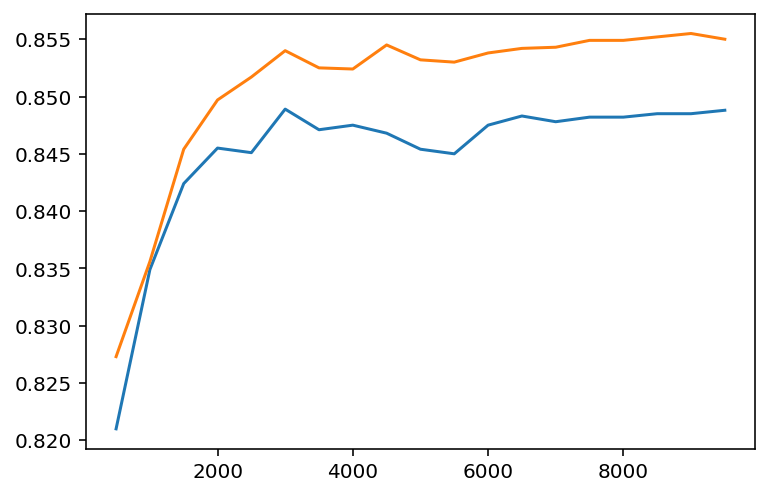

In [59]:
plt.plot(possible_n, cnt_accuracies, label='Word Count')
plt.plot(possible_n, tfidf_accuracies, label='Tf-idf')
plt.show()

** Model turns to be stable after top words >= 3000

## Save model

In [60]:
_, model, vec = train_with_n_topwords(3000, tfidf=True)

In [61]:
import pickle

with open('tf_vec.pkl', 'wb') as fp:
    pickle.dump(vec, fp)
    
with open('mnb_model.pkl', 'wb') as fp:
    pickle.dump(model, fp)

### Comming later...

### Word Embedding

### Transfer learning - BERT